In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [22]:
#https://www.kaggle.com/datasets/thedatasith/hymenoptera

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [11]:
import zipfile
import os

zip_file_path = '/content/hymenoptera_data.zip'
extraction_dir = 'hymenoptera_data'

os.makedirs(extraction_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

print(f'Extracted {zip_file_path} to {extraction_dir}')


Extracted /content/hymenoptera_data.zip to hymenoptera_data


In [12]:
data_dir = 'hymenoptera_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


print(class_names)

['ants', 'bees']


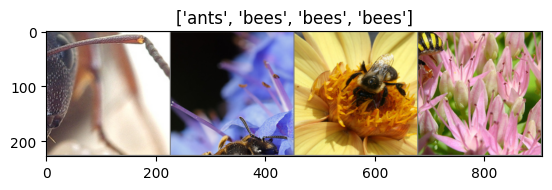

In [13]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)


        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0


            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)


                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)


                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()


                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))


    model.load_state_dict(best_model_wts)
    return model


In [15]:
model=models.resnet18(pretrained=True)
num_ftrs=model.fc.in_features
model.fc=nn.Linear(num_ftrs,2)
model=model.to(device)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


In [16]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001)

In [17]:
step_lr_scheduler=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

In [18]:
model=train_model(model,criterion,optimizer,step_lr_scheduler,num_epochs=20)


Epoch 0/19
----------
train Loss: 0.6341 Acc: 0.6680
val Loss: 0.5308 Acc: 0.7190

Epoch 1/19
----------
train Loss: 0.5406 Acc: 0.7295
val Loss: 0.3439 Acc: 0.8693

Epoch 2/19
----------
train Loss: 0.4944 Acc: 0.7541
val Loss: 0.3048 Acc: 0.8954

Epoch 3/19
----------
train Loss: 0.4953 Acc: 0.7459
val Loss: 0.2977 Acc: 0.9020

Epoch 4/19
----------
train Loss: 0.4807 Acc: 0.7828
val Loss: 0.2700 Acc: 0.9085

Epoch 5/19
----------
train Loss: 0.4070 Acc: 0.8320
val Loss: 0.2489 Acc: 0.9020

Epoch 6/19
----------
train Loss: 0.3684 Acc: 0.8525
val Loss: 0.2183 Acc: 0.9085

Epoch 7/19
----------
train Loss: 0.4129 Acc: 0.8238
val Loss: 0.2711 Acc: 0.8889

Epoch 8/19
----------
train Loss: 0.3620 Acc: 0.8648
val Loss: 0.2080 Acc: 0.9346

Epoch 9/19
----------
train Loss: 0.3740 Acc: 0.8279
val Loss: 0.2122 Acc: 0.9216

Epoch 10/19
----------
train Loss: 0.3293 Acc: 0.8730
val Loss: 0.2097 Acc: 0.9085

Epoch 11/19
----------
train Loss: 0.3611 Acc: 0.8197
val Loss: 0.2375 Acc: 0.9085

Ep

In [21]:

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.5463 Acc: 0.6926
val Loss: 0.3500 Acc: 0.8693

Epoch 1/24
----------
train Loss: 0.6408 Acc: 0.7377
val Loss: 0.2044 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.5118 Acc: 0.7787
val Loss: 0.1943 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4907 Acc: 0.8156
val Loss: 0.1957 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4235 Acc: 0.8197
val Loss: 0.2095 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.5494 Acc: 0.7623
val Loss: 0.2510 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.4616 Acc: 0.7992
val Loss: 0.2231 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.3822 Acc: 0.8525
val Loss: 0.2192 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3849 Acc: 0.8238
val Loss: 0.2296 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3640 Acc: 0.8443
val Loss: 0.2904 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.2368 Acc: 0.8893
val Loss: 0.2177 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3526 Acc: 0.8320
val Loss: 0.2218 Acc: 0.9346

Ep